In [1]:
! pip install -q kaggle

In [9]:
! kaggle datasets download gauravduttakiit/gender-determination-with-morphometry-of-eyes


100%|██████████████████████████████████████| 25.4M/25.4M [00:05<00:00, 9.85MB/s]
100%|██████████████████████████████████████| 25.4M/25.4M [00:05<00:00, 4.65MB/s]


In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from tensorflow.keras.applications.xception import Xception
# from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

from tensorflow.keras.preprocessing.image import load_img

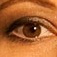

In [12]:
path = './gender_eye/train/female'
name = 'Image_4.jpg'
fullname = f'{path}/{name}'
load_img(fullname)


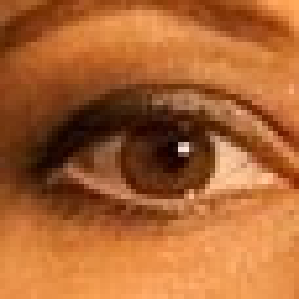

In [16]:
load_img(fullname, target_size=(299, 299))

In [14]:
img = load_img(fullname, target_size=(299, 299))
x = np.array(img)
x.shape

(299, 299, 3)

In [15]:
img = load_img(fullname,)
x = np.array(img)
x.shape

(57, 57, 3)

In [20]:
batch_size = 30

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'training', 
    )

    val_dataset = imgdatagen.flow_from_directory(
        'gender_eye/train',
        target_size = (height, width), 
        classes = ('female','male'),
        batch_size = batch_size,
        subset = 'validation'
    )
    return train_dataset, val_dataset

In [17]:
os.getcwd()

'/Users/daniel/Documents/Codes_Books/gender_determination'

In [21]:
resnet50 = keras.applications.resnet50
train_dataset, val_dataset = generators((224,224), preprocessing=resnet50.preprocess_input)

Found 8299 images belonging to 2 classes.
Found 921 images belonging to 2 classes.


In [8]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

batch_size=32

train_ds = train_gen.flow_from_directory('gender_eye/train', 
                                         target_size=(150, 150), 
                                         batch_size=batch_size,
                                         shuffle=True,
                                        #  color_mode='grayscale',
                                         class_mode='binary')

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = val_gen.flow_from_directory('gender_eye/test', 
                                     target_size=(150, 150), 
                                     batch_size=batch_size, 
                                    #  color_mode='grayscale',
                                     shuffle=False,
                                     class_mode='binary')

Found 9220 images belonging to 2 classes.
Found 0 images belonging to 0 classes.


In [11]:
len(os.listdir('gender_eye/test/'))

2305

In [ ]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(10)(vectors)

model = keras.Model(inputs, outputs)

In [22]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in conv_model.layers:
    layer.trainable = False
x = keras.layers.Flatten()(conv_model.output)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-14 23:54:49.777538: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-14 23:54:49.778968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


94765736/94765736 [==============================] - 6s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [26]:
full_model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['acc', 'AUC','Precision','Recall'])

In [28]:
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=30,
    steps_per_epoch=50,
    validation_steps = 20
)

Epoch 1/30
50/50 [==============================] - 27s 523ms/step - loss: 0.2223 - acc: 0.9240 - auc: 0.9643 - precision: 0.9240 - recall: 0.9240 - val_loss: 0.3267 - val_acc: 0.8733 - val_auc: 0.9435 - val_precision: 0.8733 - val_recall: 0.8733
Epoch 2/30
50/50 [==============================] - 26s 512ms/step - loss: 0.1739 - acc: 0.9453 - auc: 0.9755 - precision: 0.9453 - recall: 0.9453 - val_loss: 0.1979 - val_acc: 0.9300 - val_auc: 0.9739 - val_precision: 0.9300 - val_recall: 0.9300
Epoch 3/30
50/50 [==============================] - 26s 528ms/step - loss: 0.1819 - acc: 0.9340 - auc: 0.9732 - precision: 0.9340 - recall: 0.9340 - val_loss: 0.1863 - val_acc: 0.9317 - val_auc: 0.9740 - val_precision: 0.9317 - val_recall: 0.9317
Epoch 4/30
50/50 [==============================] - 26s 531ms/step - loss: 0.2648 - acc: 0.9233 - auc: 0.9623 - precision: 0.9233 - recall: 0.9233 - val_loss: 0.2585 - val_acc: 0.9233 - val_auc: 0.9641 - val_precision: 0.9233 - val_recall: 0.9233
Epoch 5/30
5

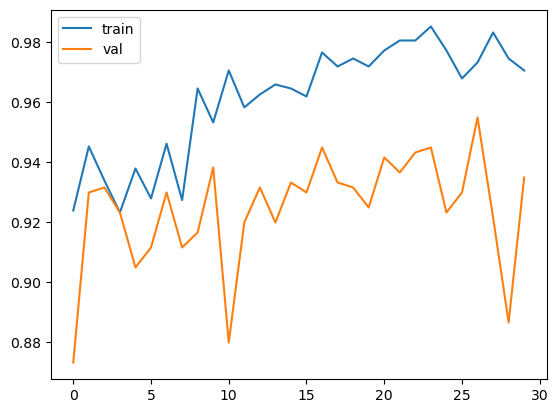

In [32]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='val')
# plt.xticks(np.arange(30))
plt.legend()
plt.show()

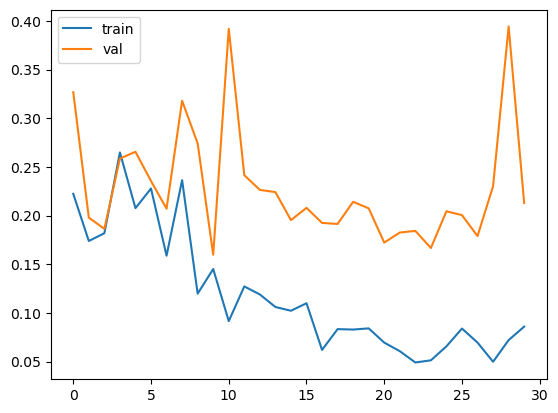

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
# plt.xticks(np.arange(30))
plt.legend()
plt.show()

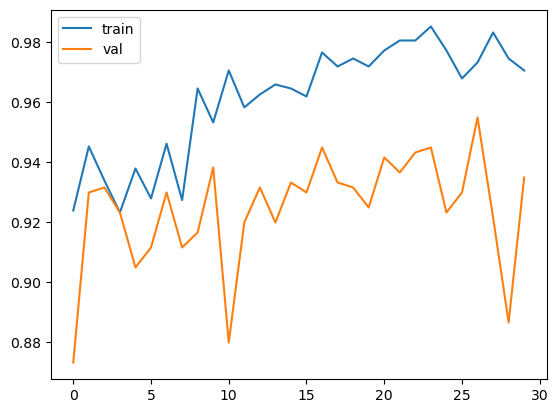

In [34]:
plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='val')
# plt.xticks(np.arange(30))
plt.legend()
plt.show()

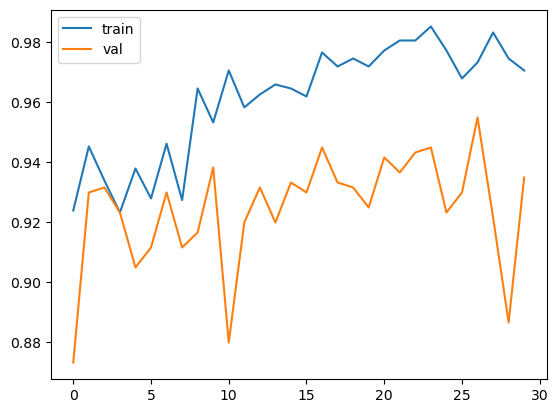

In [35]:
plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='val')
# plt.xticks(np.arange(30))
plt.legend()
plt.show()

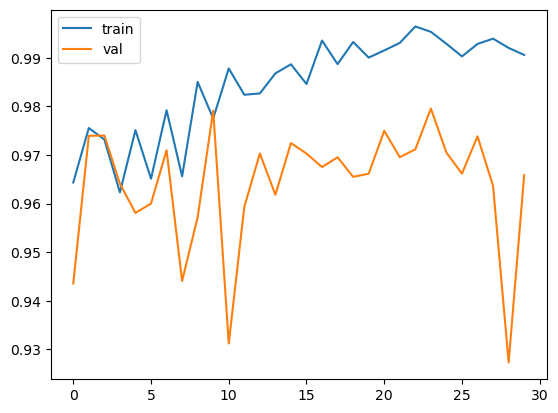

In [36]:
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='val')
# plt.xticks(np.arange(30))
plt.legend()
plt.show()